#  BRATS 3D Unet

The default network for 3D medical image segmentation is the 3D Unet


In [0]:
%%capture 

!mkdir BRATS_dkfz


!wget http://mia-software.artorg.unibe.ch/CAS_zips/dkfz_uint.zip 



!unzip 'dkfz_uint.zip' -d BRATS_dkfz

!rm dkfz_uint.zip

We need some packages: batchgenerators (to build an efficient dataloader for 3D data with augmentations) and nnunet (to get a modern implementation of a 3D Unet, with patchwise application)

In [0]:
%%capture 


!pip install --upgrade batchgenerators
!pip install SimpleITK
!pip install nnunet

In [0]:
#set this to True, if you want all the 3D image files to be loaded into memory
IN_MEMORY = False

#set this above zero to limit the number of training cases 
USE_TRAIN_CASES = 0

#set this above zero to limit the number of validation cases (to make epochs faster)
USE_VAL_CASES = 0

#data loader/augmentation settings
MAX_ROT_ANGLE = 15

P_ROT = 0.0

P_SCALE = 0.0

P_EL = 0.0

MAX_SHAPE = (192,192,192)

NUM_THREADS = 2

#training settings

NUM_EPOCHS = 2

BATCHES_PER_EPOCH = 1000

DICE_WEIGHTING = 1.0

OUTPUT_DIR = "brats_2018_local"

PATCH_SIZE = (128, 128, 128)

BATCH_SIZE = 2

GRADIENT_MASK_ZERO_VOXELS = False


In [0]:
def get_gradient_mask(batch):
  if GRADIENT_MASK_ZERO_VOXELS:
    return (batch[:,0] != 0.0).astype(np.float)
  else:
    return (np.ones_like(batch[:,0])).astype(np.float)

In [0]:
NUM_WORKERS = 4


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np


from time import time
from batchgenerators.augmentations.crop_and_pad_augmentations import crop
from batchgenerators.dataloading import MultiThreadedAugmenter
from batchgenerators.transforms import Compose
from batchgenerators.utilities.data_splitting import get_split_deterministic
from batchgenerators.utilities.file_and_folder_operations import *
from batchgenerators.dataloading.data_loader import DataLoader
from batchgenerators.augmentations.utils import pad_nd_image
from batchgenerators.transforms.spatial_transforms import SpatialTransform_2, MirrorTransform
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, GammaTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform


import os
import random
from tqdm.notebook import tqdm

#torch-related imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable, Function
#from torch.nn import BCELoss, NLLLoss, BCEWithLogitsLoss, MSELoss, ModuleList, ReplicationPad2d
#from torch.utils.data.sampler import Sampler, RandomSampler, WeightedRandomSampler, SequentialSampler
#from torch._six import int_classes as _int_classes


from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

from nnunet.network_architecture.generic_UNet import Generic_UNet






Please cite the following paper when using nnUNet:
Fabian Isensee, Paul F. Jäger, Simon A. A. Kohl, Jens Petersen, Klaus H. Maier-Hein "Automated Design of Deep Learning Methods for Biomedical Image Segmentation" arXiv preprint arXiv:1904.08128 (2020).
If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [0]:
brats_preprocessed_folder = '/content/BRATS_dkfz'

def get_list_of_patients(preprocessed_data_folder):
    npy_files = subfiles(preprocessed_data_folder, suffix=".npy", join=True)
    # remove npy file extension
    patients = [i[:-4] for i in npy_files]
    return patients

patients = get_list_of_patients(brats_preprocessed_folder)

train, val = get_split_deterministic(patients, fold=0, num_splits=5, random_state=12345)

if USE_TRAIN_CASES != 0:
  train = train[:USE_TRAIN_CASES]

if USE_VAL_CASES != 0:
  val = val[:USE_VAL_CASES]

num_val_cases = len(val)

num_train_cases = len(train)

if IN_MEMORY:
    patient_volumes = {x:np.load(x+'.npy') for x in patients}
else:
    patient_volumes = {x:np.load(x+'.npy', 'r') for x in patients}


In [0]:
 def load_patient(patient, axis = 'random'):
        if axis=='random':
          axis = np.random.choice(['axial', 'sagittal', 'coronal'])
        
        assert axis in ['axial', 'sagittal', 'coronal']


        data = patient_volumes[patient]

        if axis == 'coronal':
          data = np.swapaxes(data, 1,2)

        if axis == 'sagittal':
          data = np.swapaxes(data, 1,3)
        metadata = load_pickle(patient + ".pkl")

        return data, metadata

class BraTS2017DataLoader3D(DataLoader):
    def __init__(self, data, batch_size, patch_size, num_threads_in_multithreaded, seed_for_shuffle=1234,
                 return_incomplete=False, shuffle=True, infinite=True):
        """
        data must be a list of patients as returned by get_list_of_patients (and split by get_split_deterministic)
        patch_size is the spatial size the retured batch will have
        """
        super().__init__(data, batch_size, num_threads_in_multithreaded, seed_for_shuffle, return_incomplete, shuffle,
                         infinite)
        self.patch_size = patch_size
        self.num_modalities = 4
        self.indices = list(range(len(data)))

    @staticmethod
   

    def generate_train_batch(self):
        # DataLoader has its own methods for selecting what patients to use next, see its Documentation
        idx = self.get_indices()
        patients_for_batch = [self._data[i] for i in idx]

        # initialize empty array for data and seg
        data = np.zeros((self.batch_size, self.num_modalities, *self.patch_size), dtype=np.float32)
        seg = np.zeros((self.batch_size, 1, *self.patch_size), dtype=np.float32)

        metadata = []
        patient_names = []

        # iterate over patients_for_batch and include them in the batch
        for i, j in enumerate(patients_for_batch):
            patient_data, patient_metadata = self.load_patient(j)

            patient_data = patient_data.astype(np.double)

            # this will only pad patient_data if its shape is smaller than self.patch_size
            patient_data = pad_nd_image(patient_data, self.patch_size)

            # now random crop to self.patch_size
            # crop expects the data to be (b, c, x, y, z) but patient_data is (c, x, y, z) so we need to add one
            # dummy dimension in order for it to work (@Todo, could be improved)
            patient_data, patient_seg = crop(patient_data[:-1][None], patient_data[-1:][None], self.patch_size, crop_type="random")

            zero_mask = patient_data == 0
            patient_data = patient_data - np.array(patient_metadata['means'])[:,np.newaxis,np.newaxis,np.newaxis]
            patient_data = patient_data/np.array(patient_metadata['sds'])[:,np.newaxis,np.newaxis,np.newaxis]

            patient_data[zero_mask] = 0.0

            data[i] = patient_data[0]
            seg[i] = patient_seg[0]

            metadata.append(patient_metadata)
            patient_names.append(j)

        return {'data': data, 'seg':seg, 'metadata':metadata, 'names':patient_names, }


In [0]:
def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # the first thing we want to run is the SpatialTransform. It reduces the size of our data to patch_size and thus
    # also reduces the computational cost of all subsequent operations. All subsequent operations do not modify the
    # shape and do not transform spatially, so no border artifacts will be introduced
    # Here we use the new SpatialTransform_2 which uses a new way of parameterizing elastic_deform
    # We use all spatial transformations with a probability of 0.2 per sample. This means that 1 - (1 - 0.1) ** 3 = 27%
    # of samples will be augmented, the rest will just be cropped
    tr_transforms.append(
        SpatialTransform_2(
            patch_size, [i // 2 for i in patch_size],
            do_elastic_deform=True, deformation_scale=(0, 0.25),
            do_rotation=True,
            angle_x=(- MAX_ROT_ANGLE  / 360. * 2 * np.pi, MAX_ROT_ANGLE  / 360. * 2 * np.pi),
            angle_y=(- MAX_ROT_ANGLE  / 360. * 2 * np.pi, MAX_ROT_ANGLE  / 360. * 2 * np.pi),
            angle_z=(- MAX_ROT_ANGLE  / 360. * 2 * np.pi, MAX_ROT_ANGLE  / 360. * 2 * np.pi),
            do_scale=True, scale=(0.75, 1.25),
            border_mode_data='constant', border_cval_data=0,
            border_mode_seg='constant', border_cval_seg=0,
            order_seg=1, order_data=3,
            random_crop=True,
            p_el_per_sample=P_EL, p_rot_per_sample=P_ROT, p_scale_per_sample=P_SCALE
        )
    )

    # now we mirror along all axes
    tr_transforms.append(MirrorTransform(axes=(0, 1, 2)))

    # brightness transform for 15% of samples
    tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=0.15))

    # gamma transform. This is a nonlinear transformation of intensity values
    # (https://en.wikipedia.org/wiki/Gamma_correction)
    tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=0.15))
    
  
    # Gaussian Noise
    #tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.15))

    # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
    # thus make the model more robust to it
    tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 1.5), different_sigma_per_channel=True,
                                               p_per_channel=0.5, p_per_sample=0.15))

    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms

In [0]:




# now we have some DataLoader. Let's go an get some augmentations

# first let's collect all shapes, you will see why later


# we create a new instance of DataLoader. This one will return batches of shape max_shape. Cropping/padding is
# now done by SpatialTransform. If we do it this way we avoid border artifacts (the entire brain of all cases will
# be in the batch and SpatialTransform will use zeros which is exactly what we have outside the brain)
# this is viable here but not viable if you work with different data. If you work for example with CT scans that
# can be up to 500x500x500 voxels large then you should do this differently. There, instead of using max_shape you
# should estimate what shape you need to extract so that subsequent SpatialTransform does not introduce border
# artifacts
dataloader_train = BraTS2017DataLoader3D(train, BATCH_SIZE, MAX_SHAPE, NUM_THREADS)


tr_transforms = get_train_transform(PATCH_SIZE)

# finally we can create multithreaded transforms that we can actually use for training
# we don't pin memory here because this is pytorch specific.
tr_gen = MultiThreadedAugmenter(dataloader_train, tr_transforms, num_processes=NUM_THREADS,
                                num_cached_per_queue=20,
                                seeds=None, pin_memory=True)
#


tr_gen.restart()


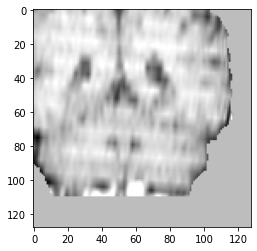

In [0]:
batch = tr_gen.next()
image_data = batch['data']
seg_data = batch['seg']
plt.imshow(image_data[0,0, 64], cmap='gray')

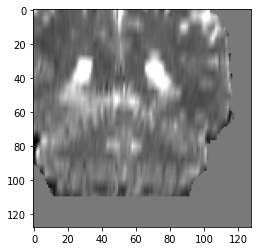

In [0]:
plt.imshow(image_data[0,2, 64], cmap='gray')

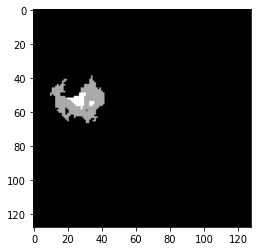

In [0]:
plt.imshow(seg_data[0,0, 64], cmap='gray')

In [0]:

target_label_sets = [ [3],
                     [1,3],
                     [1,2,3]
                    ]
target_label_names = ['enhancing', 'tumor_core', 'whole_tumor']

assert len(target_label_names) == len(target_label_sets)




total_with_gradient = 0

total_positives = np.array([0,0,0])

for case in train:


  total_with_gradient += np.sum(get_gradient_mask(patient_volumes[case][np.newaxis]))

  total_positives += [np.sum(np.isin(patient_volumes[case][-1], x)) for x in target_label_sets]

label_prevalences = total_positives/total_with_gradient
list(zip(label_prevalences,target_label_names))


[(0.005920891170929659, 'enhancing'),
 (0.012426714782795903, 'tumor_core'),
 (0.030403128185577867, 'whole_tumor')]

In [0]:
def make_target(gt):
  return np.concatenate([np.isin(gt,labelset).astype(np.float) for labelset in target_label_sets], axis =1)


In [0]:
class Average(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val
        self.count += n

    @property
    def avg(self):
        return self.sum / self.count

In [0]:
class BCE_from_logits(nn.modules.Module):
    def __init__(self):
        super(BCE_from_logits,self).__init__()
    def forward(self, input, target):
        #input = input.clamp(min = -1, max = 1)
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()
        return loss
    
class BCE_from_logits_focal(nn.modules.Module):
    def __init__(self, gamma):
        super(BCE_from_logits_focal,self).__init__()
        self.gamma = gamma
    def forward(self, input, target):
        #input = input.clamp(min = -1, max = 1)
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()
        p = input.sigmoid()
        pt = (1-p)*(1-target) + p*target
        return ((1-pt).pow(self.gamma))*loss




from nnunet.training.loss_functions.dice_loss import SoftDiceLossSquared

dice_loss = SoftDiceLossSquared()


In [0]:
import os, sys
#this helper function just redirects the print statments from nnUnet, which are quite verbose :-) 
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def apply_to_case(model, patient, soft_dice_weighting = 0, do_mirroring=False, patch_size=PATCH_SIZE, axes=['axial'], 
                 size=(192,192)):
    model.eval()
    with torch.no_grad():
      volume_0 =  np.load(patient+'.npy')[0]


      ensemble_flips = []
      ensemble_logits = []

      patient_data, patient_metadata = load_patient(patient, axis='axial')
      masks = pad_nd_image(patient_data[-1],patch_size)
      full_image =  pad_nd_image(patient_data[:-1],patch_size)
      full_mask =  np.stack([np.isin(masks,labelset).astype(np.float) for labelset in target_label_sets], axis =0)
      gradient_mask = get_gradient_mask(full_image[np.newaxis,:]).astype(np.uint8)[0]
      for axis in axes:
          
          all_data, patient_metadata = load_patient(patient, axis=axis)
          image_data =  pad_nd_image(all_data[:-1], patch_size)
          zero_mask = (image_data != 0).astype(np.uint8)
          image_data = image_data - np.array(patient_metadata['means'])[:,np.newaxis,np.newaxis,np.newaxis]
          image_data = image_data/np.array(patient_metadata['sds'])[:,np.newaxis,np.newaxis,np.newaxis]

          image_data = image_data * zero_mask
          with HiddenPrints():
            output = unet.predict_3D(torch.from_numpy(image_data),do_mirroring=do_mirroring, patch_size=patch_size,tiled=True)
          
          output = output[2]

          if axis == 'coronal':
              output = np.swapaxes(output, 1,2)

          if axis == 'sagittal':
              output = np.swapaxes(output, 1,3)
          
          ensemble_logits.append(output)



          
      full_logit = np.mean(np.array(ensemble_logits),axis=0)

      full_logit = full_logit * np.expand_dims(gradient_mask,0)
      
      
      TP = np.sum(np.logical_and(full_logit>0 , full_mask>0), axis=(1,2,3))
      FP = np.sum(np.logical_and(full_logit>0 , full_mask==0), axis=(1,2,3))
      FN = np.sum(np.logical_and(full_logit<0 , full_mask>0), axis=(1,2,3))
      TN = np.sum(np.logical_and(full_logit<0 , full_mask==0), axis=(1,2,3))
      

      loss = BCE_from_logits()(torch.Tensor(full_logit), torch.Tensor(full_mask)).numpy()
      
      
      soft_dice = dice_loss(torch.Tensor(full_mask).unsqueeze(0), torch.Tensor(full_logit).unsqueeze(0).sigmoid()).numpy()


      
      return full_image, full_mask, full_logit, loss, soft_dice, TP, FP, TN, FN

In [0]:
def logistic(y):
  return np.log(y/(1-y))

def sigmoid(y):
  return np.exp(y)/(1 + np.exp(y))

In [0]:
from torch.optim.lr_scheduler import _LRScheduler

class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.

        from https://github.com/davidtvs/pytorch-lr-finder/
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

In [0]:


from sortedcontainers import SortedDict
import shutil
from sklearn.metrics import f1_score

#folder = 'unet_brats_2018_{}/'.format(stack_depth)
folder = OUTPUT_DIR + "/"
avg_net = None

import os
if not os.path.exists(folder):
    os.makedirs(folder)

def save_checkpoint(state, epoch, permanent_save, filename=folder+'/checkpoint.pth.tar'):
    torch.save(state, filename)
    if permanent_save:
        shutil.copyfile(filename, folder+str(epoch)+'_checkpoint.pth.tar')
from tqdm import trange


def train_unet(net = None,num_epochs = 50, batches_per_train_epoch = 20, num_val_cases = 1,
                  dice_weighting = DICE_WEIGHTING, lr_max = 0.0001,
                  lr_min = 0.00000001, scheduler = 'one-cycle', lr_find = False, lr_find_steps = 100, evaluate = True):
    
    optimizer = optim.Adam(net.parameters(), lr=lr_max, weight_decay=0.00001)
    loader = tr_gen
    epochs_this_run = 0

    lr_history = []

    loss_history = []

    if lr_find:
      num_epochs = 1
      batches_per_train_epoch = lr_find_steps
      evaluate = False


    if lr_find:
          for param_group in optimizer.param_groups:
            param_group['lr'] = lr_min
          schedule = ExponentialLR(optimizer, end_lr = lr_max, num_iter = lr_find_steps)
    elif scheduler == 'cosine':
          print('using per-epoch cosine annealing')
          for param_group in optimizer.param_groups:
            param_group['lr'] = lr_max
          schedule = CosineAnnealingLR(optimizer, T_max = batches_per_train_epoch, eta_min=lr_min)
    else:
          print('using one-cycle')
          div_factor = 25
          for param_group in optimizer.param_groups:
            param_group['lr'] = lr_max/25
            schedule = OneCycleLR(optimizer, max_lr = lr_max, epochs = num_epochs, steps_per_epoch = batches_per_train_epoch, div_factor = 25)
    for epoch in tqdm(range(0, num_epochs)):
        
        epochs_this_run = epochs_this_run+1

        if scheduler == 'cosine':
          for param_group in optimizer.param_groups:
            param_group['lr'] = lr_max
          schedule = CosineAnnealingLR(optimizer, T_max = batches_per_train_epoch, eta_min=lr_min)

        train_loss = Average()
        soft_dice_loss = Average()
                
        net.train()
        t = tqdm(range(batches_per_train_epoch),leave=True)
        for iter in  t:
            lr_history.append(schedule.get_lr())
            this_batch = tr_gen.next()
            images = this_batch['data']
            masks = this_batch['seg']

            gradient_masks = get_gradient_mask(images)


            masks = torch.from_numpy(make_target(masks))
            images = torch.from_numpy(images)
            gradient_masks = torch.from_numpy(gradient_masks)


            optimizer.zero_grad()

            outputs = net(Variable(images).cuda())

            outputs = outputs[0]*gradient_masks.unsqueeze(1).cuda()

            
            total_loss = 0
            

            masks = (masks).cuda(async=True)
            gradient_mask = (gradient_masks).cuda(async=True) 



            loss = BCE_from_logits()(outputs,masks.cuda())

            soft_dice = 1 + dice_loss(masks.cuda(), outputs.sigmoid())

            total_loss = loss.sum() 


            train_loss.update(total_loss.item(), torch.sum(gradient_mask != 0).item())
            soft_dice_loss.update(soft_dice.item(), gradient_mask.shape[0])


            eps=1e-10
            total_loss = total_loss/(torch.sum(gradient_mask != 0.0) + eps) + soft_dice*dice_weighting
            
            outputs_prob = torch.sigmoid(outputs)

            total_loss.backward()

            optimizer.step()
           # optimizer2.step()
            train_loss.update(total_loss.item(), images.size(0))
            loss_history.append(total_loss.item())

            t.set_description(f'Loss = {train_loss.avg:.4f}, {soft_dice_loss.avg:.4f}')
            schedule.step()
                        
        
        #loss = (criterion(outputs, masks)[0] +(-logit_flip).exp()[0]).data.cpu().numpy()
        
        all_dices = []

        if evaluate:
          val_loss = Average()

          val_dice_loss = Average()
          
          
          val_dice = [Average() for x in target_label_sets]
          
          net.eval()
          
          
          result_summary = list()

          all_dices = []
          for case in tqdm(range(num_val_cases), leave=False): 
              patient = val[case]
              full_image, full_mask, full_logit, losses, val_dice_loss, TP, FP, TN, FN = apply_to_case(net,patient=patient,
                                                                        axes=['axial','sagittal','coronal'])
              
              total_voxels = np.prod(np.load(patient+'.npy').shape)
              
              vloss = np.sum(losses) 
              
              
              vloss = vloss/total_voxels
              val_loss.update(vloss, 1)
              

              epsilon = 0.000001
              dices = (2*TP+epsilon)/(2*TP+FP+FN+epsilon)


              all_dices.append(dices)
        
          print(np.mean(all_dices, 0))           
    return net, all_dices, lr_history, loss_history

In [0]:
num_val_cases

67

In [0]:
unet = Generic_UNet(input_channels=4, base_num_features=12, num_classes=3, num_pool=4, num_conv_per_stage=2,
                 feat_map_mul_on_downscale=2, conv_op=nn.Conv3d,
                 norm_op=nn.InstanceNorm3d, norm_op_kwargs=None,
                 dropout_op=nn.Dropout3d, dropout_op_kwargs=None,
                 nonlin=nn.LeakyReLU,deep_supervision=False,final_nonlin = nn.Identity(), seg_output_use_bias=True)

pytorch_total_params = sum(np.fromiter((p.numel() for p in unet.parameters()), int))
print(pytorch_total_params)

unet = unet.cuda()

pi = np.array(label_prevalences)

new_bias = torch.from_numpy(-np.log(((1-pi)/pi)))


unet.seg_outputs[-1].bias = torch.nn.Parameter(new_bias.float().cuda())




2321616


In [0]:
unet.seg_outputs[3].bias

Parameter containing:
tensor([-5.1233, -4.3754, -3.4623], device='cuda:0', requires_grad=True)

In [0]:
tr_gen.restart()

net, dices, lr_history, loss_history = train_unet(unet, NUM_EPOCHS,batches_per_train_epoch=1000, dice_weighting = DICE_WEIGHTING, lr_max=1e-1, lr_min=1e-8, 
                            lr_find = True, lr_find_steps = 500)

(0.9351805374595602, 1.4495551744036284)

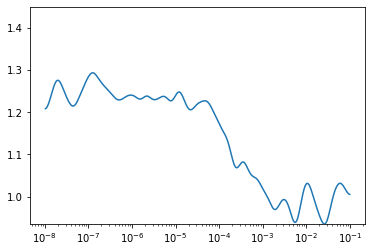

In [0]:
from scipy.ndimage.filters import gaussian_filter1d

ysmoothed = gaussian_filter1d(loss_history, sigma=8)



plt.plot(lr_history, ysmoothed)
plt.xscale('log')
plt.ylim(np.min(ysmoothed),1.2*ysmoothed[0])

In [0]:
tr_gen.restart()

NUM_EPOCHS=4

net, dices, lr_history, loss_history = train_unet(unet, NUM_EPOCHS,batches_per_train_epoch=BATCHES_PER_EPOCH, dice_weighting = DICE_WEIGHTING, lr_max=1e-3,scheduler = 'one_cycle', num_val_cases = num_val_cases)

using one-cycle


[0.4934235  0.5056152  0.65169086]


[0.53988136 0.51159949 0.71834195]


[0.542679   0.48563476 0.71801875]
